In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

r = 0.05  # базовая процентная ставка 5%

1. Загрузка таблицы

In [2]:
# Таблица смертности
data = pd.read_excel('life_table.xlsx', sheet_name='Лист1')

# Словарь для быстрого доступа к значениям lx по возрасту
lx_dict = dict(zip(data['Age'], data['lx']))

# l_50 (количество доживающих до 50 лет)
l_50 = lx_dict[50]

# Нормализация вероятности дожития
def get_survival_probability(age):  # Возвращает вероятность дожить до указанного возраста, начиная с 50 лет
    if age in lx_dict:
        return lx_dict[age] / l_50
    else:
        # Если возраст выходит за пределы
        max_age = max(lx_dict.keys()), 
        if age > max_age:
            return 0.0
        else:
            # Линейная интерполяция для остальных
            ages = sorted(lx_dict.keys())
            for i in range(len(ages)-1):
                if ages[i] <= age <= ages[i+1]:
                    t = (age - ages[i]) / (ages[i+1] - ages[i]) # насколько близко искомый возраст к нижней границе интервала
                    lx_interp = lx_dict[ages[i]] * (1-t) + lx_dict[ages[i+1]] * t # приближенное значение lx
                    return lx_interp / l_50
            return 0.0


2. Поток платежей для обязательств

In [3]:
def calculate_liabilities_cashflows_real_mortality(max_years=50): # Рассчитывает поток платежей для обязательств
    years = np.arange(1, max_years + 1)
    ages_client = 50 + years
    
    # Аннуитет: платежи с 65 лет (1000 ежегодно)
    annuity_payments = np.where(ages_client >= 65, 1000, 0)
    
    # Страхование дожития: выплата 10000 в 5-й год
    insurance_payments = np.where(years == 5, 10000, 0)
    
    # Вероятности выплат по аннуитету (показывают шанс дожить до этого возраста)
    annuity_prob = np.array([get_survival_probability(age) for age in ages_client])
    
    # Для страхования дожития: 
    # - для первых 4 лет: вероятность умереть в течение года
    # - для года 5-го: вероятность дожить до 55 лет
    insurance_prob = np.zeros_like(years, dtype=float)
    
    for i, year in enumerate(years):
        current_age = 50 + year
        if year <= 4:
            # Вероятность умереть между (50+year-1) и (50+year)
            prob_survive_prev = get_survival_probability(50 + year - 1)
            prob_survive_current = get_survival_probability(50 + year)
            insurance_prob[i] = prob_survive_prev - prob_survive_current
        elif year == 5:
            # Вероятность дожить до 5-го года (до 55 лет)
            insurance_prob[i] = get_survival_probability(55)
    
    # Общий поток платежей
    total_cashflow = annuity_payments * annuity_prob + insurance_payments * insurance_prob
    
    df = pd.DataFrame({
        'Год': years,
        'Возраст': ages_client,
        'Аннуитет_платеж': annuity_payments,
        'Аннуитет_вероятность': annuity_prob,
        'Аннуитет_ожидание': annuity_payments * annuity_prob,
        'Страхование_платеж': insurance_payments,
        'Страхование_вероятность': insurance_prob,
        'Страхование_ожидание': insurance_payments * insurance_prob,
        'Общий_Платеж': total_cashflow
    })
    
    return df, total_cashflow

# Поток платежей
liabilities_df, liabilities_cashflow = calculate_liabilities_cashflows_real_mortality()
print(liabilities_df.head(25))


    Год  Возраст  Аннуитет_платеж  Аннуитет_вероятность  Аннуитет_ожидание  \
0     1       51                0              0.993784           0.000000   
1     2       52                0              0.987156           0.000000   
2     3       53                0              0.980085           0.000000   
3     4       54                0              0.972503           0.000000   
4     5       55                0              0.964377           0.000000   
5     6       56                0              0.955663           0.000000   
6     7       57                0              0.946327           0.000000   
7     8       58                0              0.936325           0.000000   
8     9       59                0              0.925657           0.000000   
9    10       60                0              0.914279           0.000000   
10   11       61                0              0.902190           0.000000   
11   12       62                0              0.889313         

3. PV, Дюрация и Выпуклость для обязательств

In [4]:
def calculate_pv_duration_convexity(cashflows, rate):  # Рассчитывает PV, Дюрацию и Выпуклость для потока платежей
    years = np.arange(1, len(cashflows) + 1)
    discount_factors = np.exp(-rate * years)
    
    pv = np.sum(cashflows * discount_factors)
    
    # Дюрация (в годах)
    weighted_pv = years * cashflows * discount_factors
    duration = np.sum(weighted_pv) / pv
    
    # Выпуклость
    convexity_weighted = (years ** 2) * cashflows * discount_factors
    convexity = np.sum(convexity_weighted) / pv
    
    return pv, duration, convexity

# Расчет для обязательств
pv_liab, duration_liab, convexity_liab = calculate_pv_duration_convexity(
    liabilities_cashflow, r
)

print(f"PV: {pv_liab:.2f}")
print(f"Дюрация: {duration_liab:.2f} лет")
print(f"Выпуклость: {convexity_liab:.2f}")


PV: 12053.26
Дюрация: 11.80 лет
Выпуклость: 232.93


4. Создание модели облигаций

In [5]:
def calculate_bond_characteristics(bond_type, target_pv=12000, rate=0.05): # Рассчитывает характеристики облигаций, масштабированные под целевой PV
    
    if bond_type == '5yr':
        years = np.arange(1, 6)
        # 8% купонная облигация
        coupon_rate = 0.08
        cashflows = np.full(5, coupon_rate * 1000)  # купоны
        cashflows[-1] += 1000  # номинал
        
    elif bond_type == '15yr':
        years = np.arange(1, 16)
        # 8% купонная облигация
        coupon_rate = 0.08
        cashflows = np.full(15, coupon_rate * 1000)  # купоны
        cashflows[-1] += 1000  # номинал
        
    elif bond_type == '30yr_zero':
        # Бескупонная облигация
        years = np.array([30])
        cashflows = np.array([1000])  # номинал
    
    # Расчет PV для номинала 1000
    discount_factors = np.exp(-rate * years)
    pv_nominal = np.sum(cashflows * discount_factors)
    
    # Масштабируем до целевого PV
    scale_factor = target_pv / pv_nominal
    scaled_cashflows = cashflows * scale_factor
    
    # Пересчитываем характеристики с масштабированными cashflows
    pv = np.sum(scaled_cashflows * discount_factors)
    
    # Дюрация (не меняется при масштабировании!)
    weighted_pv = years * scaled_cashflows * discount_factors
    duration = np.sum(weighted_pv) / pv
    
    # Выпуклость (не меняется при масштабировании!)
    convexity_weighted = (years ** 2) * scaled_cashflows * discount_factors
    convexity = np.sum(convexity_weighted) / pv
    
    return years, scaled_cashflows, pv, duration, convexity, scale_factor

# Пересчитываем характеристики облигаций с правильным масштабированием
# print("\nПЕРЕСЧЕТ ОБЛИГАЦИЙ С МАСШТАБИРОВАНИЕМ:")
bond_types = ['5yr', '15yr', '30yr_zero']
bonds_final = {}

for bond_type in bond_types:
    years, cashflows, pv, duration, convexity, scale_factor = calculate_bond_characteristics(bond_type, pv_liab)
    
    bonds_final[bond_type] = {
        'years': years,
        'cashflows': cashflows,
        'pv': pv,
        'duration': duration,
        'convexity': convexity,
        'scale_factor': scale_factor
    }
    
    print(f"\n{bond_type.upper()}:")
    print(f"PV: {pv:.2f} (масштаб: {scale_factor:.2f}x)")
    print(f"Дюрация: {duration:.2f} лет")
    print(f"Выпуклость: {convexity:.2f}")
    print(f"Пример cashflow: {cashflows[0]:.2f} (первый платеж)")

# Используем финальные данные
bonds = bonds_final

# Теперь PV облигаций сопоставим с PV обязательств!
print(f"\nСравнение:")
print(f"PV обязательств: {pv_liab:.2f}")
print(f"PV облигаций: 5yr={bonds['5yr']['pv']:.2f}, 15yr={bonds['15yr']['pv']:.2f}, 30yr={bonds['30yr_zero']['pv']:.2f}")



5YR:
PV: 12053.26 (масштаб: 10.72x)
Дюрация: 4.36 лет
Выпуклость: 20.52
Пример cashflow: 857.93 (первый платеж)

15YR:
PV: 12053.26 (масштаб: 9.30x)
Дюрация: 9.96 лет
Выпуклость: 125.37
Пример cashflow: 744.23 (первый платеж)

30YR_ZERO:
PV: 12053.26 (масштаб: 54.02x)
Дюрация: 30.00 лет
Выпуклость: 900.00
Пример cashflow: 54018.97 (первый платеж)

Сравнение:
PV обязательств: 12053.26
PV облигаций: 5yr=12053.26, 15yr=12053.26, 30yr=12053.26


5. Решение системы уравнений для иммунизации

In [6]:
def solve_immunization_weights(bonds, pv_liab, duration_liab, convexity_liab): # Решает систему уравнений для нахождения весов иммунизации
    
    # Матрица коэффициентов
    A = np.array([
        [1, 1, 1],  # сумма весов = 1
        [bonds['5yr']['duration'], bonds['15yr']['duration'], bonds['30yr_zero']['duration']],  # дюрации
        [bonds['5yr']['convexity'], bonds['15yr']['convexity'], bonds['30yr_zero']['convexity']]  # выпуклости
    ])
    print(A)
    print(f"\n")
    
    # Вектор правых частей
    b = np.array([1, duration_liab, convexity_liab])
    print(b)
    
    try:
        # Решаем систему линейных уравнений
        weights = np.linalg.solve(A, b)
        return weights
    except np.linalg.LinAlgError:
        print("Система вырождена, используем метод наименьших квадратов")
        weights, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
        return weights

# Находим веса иммунизации
weights = solve_immunization_weights(bonds, pv_liab, duration_liab, convexity_liab)
print(f"\n")

for i, bond_type in enumerate(bond_types):
    print(f"{bond_type}: {weights[i]:.4f} ({weights[i]*100:.2f}%)")

# Проверка
total_weight = np.sum(weights)
portfolio_duration = np.sum([weights[i] * bonds[bond_type]['duration'] for i, bond_type in enumerate(bond_types)])
portfolio_convexity = np.sum([weights[i] * bonds[bond_type]['convexity'] for i, bond_type in enumerate(bond_types)])

print(f"\n")
print(f"Дюрация: {portfolio_duration:.2f} лет (правильно: {duration_liab:.2f} лет)")
print(f"Выпуклость: {portfolio_convexity:.2f} (правильно: {convexity_liab:.2f})")


[[  1.           1.           1.        ]
 [  4.35515889   9.96450155  30.        ]
 [ 20.51786039 125.37311679 900.        ]]


[  1.          11.80098748 232.93104758]


5yr: 0.3263 (32.63%)
15yr: 0.4906 (49.06%)
30yr_zero: 0.1830 (18.30%)


Дюрация: 11.80 лет (правильно: 11.80 лет)
Выпуклость: 232.93 (правильно: 232.93)


6. Анализ сценариев (New York Seven)

In [7]:
def generate_scenarios():
    
    n = 50
    half = n // 2
    r0 = 0.05

    scenarios = []

    # 1) 5 → 5 (константа)
    s1 = np.full(n, 0.05)
    scenarios.append(s1)

    # 2) 5 → 8 линейно 50 лет
    s2 = np.linspace(0.05, 0.08, n)
    scenarios.append(s2)

    # 3) 5 → 2 линейно 50 лет
    s3 = np.linspace(0.05, 0.02, n)
    scenarios.append(s3)

    # 4) 5 → 8 за 25 лет → 5 за 25 лет
    s4 = np.concatenate([
        np.linspace(0.05, 0.08, half),
        np.linspace(0.08, 0.05, half)
    ])
    scenarios.append(s4)

    # 5) 5 → 2 за 25 лет → 5 за 25 лет
    s5 = np.concatenate([
        np.linspace(0.05, 0.02, half),
        np.linspace(0.02, 0.05, half)
    ])
    scenarios.append(s5)

    # 6) 5 → 8 за 25 лет → 8 константа
    s6 = np.concatenate([
        np.linspace(0.05, 0.08, half),
        np.full(half, 0.08)
    ])
    scenarios.append(s6)

    # 7) 5 → 2 за 25 лет → 2 константа
    s7 = np.concatenate([
        np.linspace(0.05, 0.02, half),
        np.full(half, 0.02)
    ])
    scenarios.append(s7)

    return scenarios

def analyze_scenarios(weights, bonds, liabilities_cashflow):

    scenarios = generate_scenarios()
    results = []

    liability_years = np.arange(1, len(liabilities_cashflow) + 1)

    for idx, rate_path in enumerate(scenarios, start=1):

        # --- PV активов ---
        pv_assets = 0
        for i, bond_type in enumerate(bond_types):
            years = bonds[bond_type]['years']     # массив лет отдельной облигации
            cashflows = bonds[bond_type]['cashflows']

            # ставка на соответствующий год
            discount_rates = rate_path[years - 1]

            discount_factors = np.exp(-discount_rates * years)
            bond_pv = np.sum(cashflows * discount_factors)

            pv_assets += weights[i] * bond_pv

        # --- PV обязательств ---
        liability_rates = rate_path[:len(liabilities_cashflow)]
        liability_discount = np.exp(-liability_rates * liability_years)
        pv_liabilities = np.sum(liabilities_cashflow * liability_discount)

        surplus = pv_assets - pv_liabilities
        surplus_percent = (surplus / pv_liabilities) * 100

        results.append({
            'Сценарий': f"S{idx}",
            'PV_Активов': pv_assets,
            'PV_Пассивы': pv_liabilities,
            'Сюрпляс': surplus,
            'Сюрпляс_%': surplus_percent
        })

    return pd.DataFrame(results)

scenarios_df = analyze_scenarios(weights, bonds, liabilities_cashflow)
print(scenarios_df.round(3))


  Сценарий  PV_Активов  PV_Пассивы  Сюрпляс  Сюрпляс_%
0       S1   12053.261   12053.261   -0.000     -0.000
1       S2   10708.044   10723.914  -15.870     -0.148
2       S3   14086.312   14147.066  -60.754     -0.429
3       S4   10047.025   10046.637    0.388      0.004
4       S5   15556.346   15531.756   24.590      0.158
5       S6    9901.875    9895.821    6.053      0.061
6       S7   16312.140   16339.289  -27.149     -0.166


S1. Ставка 5% - 5% все 50 лет

S2. 5% - 8% за 50 лет

S3. 5% - 2% за 50 лет

S4. 5% - 8% за 25 лет - 5%

S5. 5% - 2% за 25 лет - 5%

S6. 5% - 8% за 25 лет - 8%

S7. 5% - 2% за 25 лет - 2%

7. Визуализация

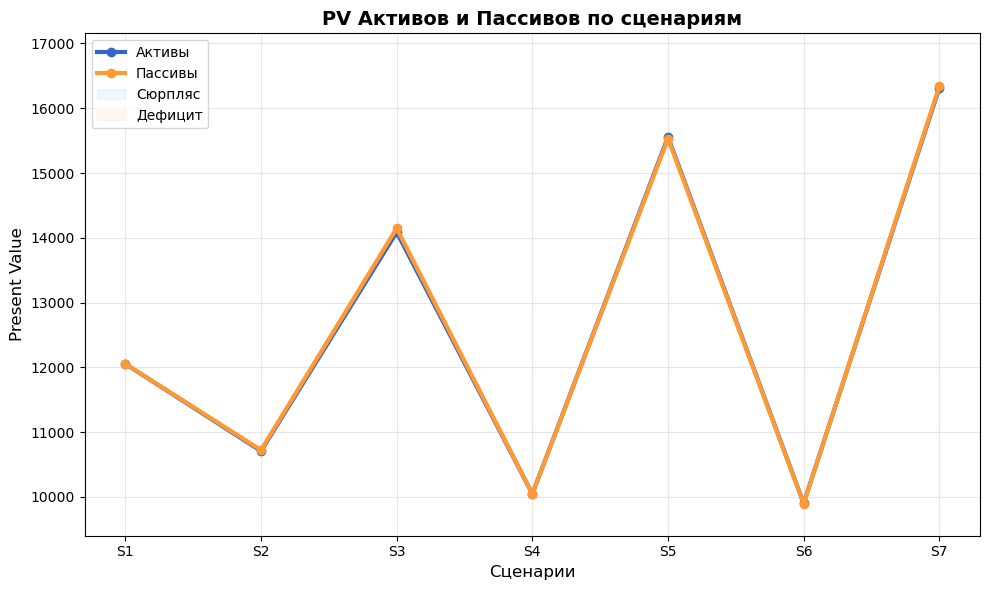

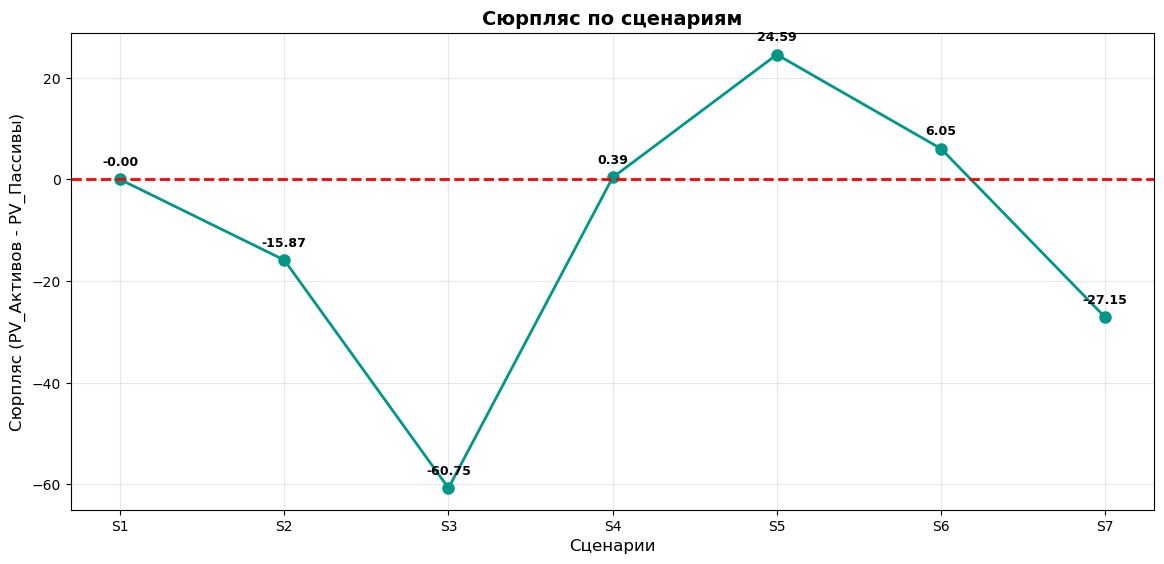

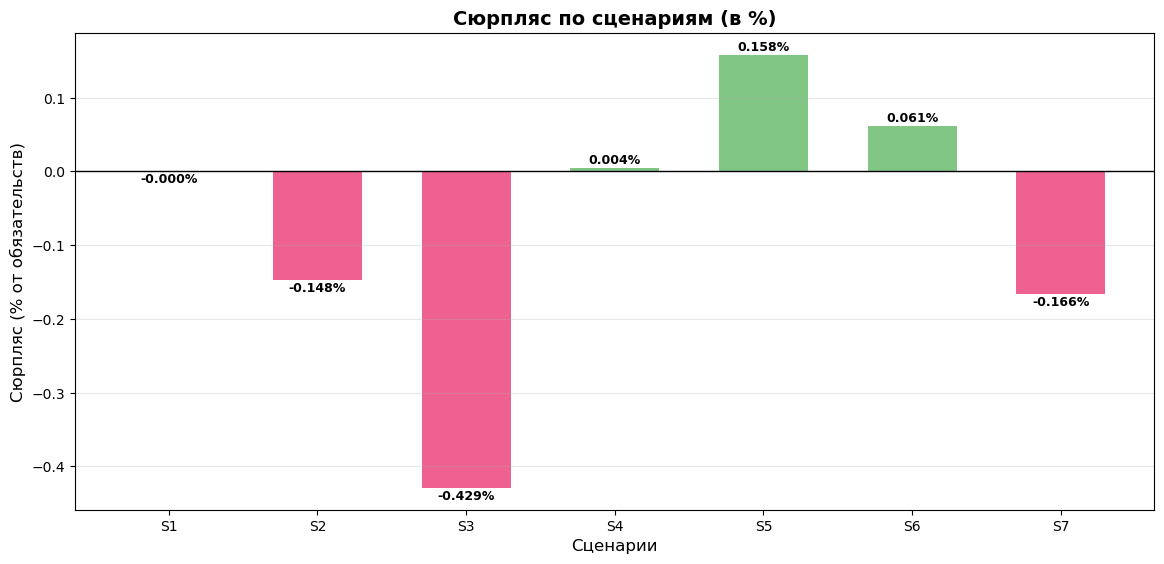

In [8]:
import matplotlib.pyplot as plt

def plot_graphs(scenarios_df, weights, data): 
    # Визуализация результатов сценариев с новыми цветами

    # 1. График PV активов и обязательств
    plt.figure(figsize=(10, 6))
    
    plt.plot(scenarios_df['Сценарий'], scenarios_df['PV_Активов'],
             color='#3366cc', marker='o', linestyle='-', linewidth=3, label='Активы')
    plt.plot(scenarios_df['Сценарий'], scenarios_df['PV_Пассивы'],
             color='#ff9933', marker='o', linestyle='-', linewidth=3, label='Пассивы')

    # Заполнение сюрпласа и дефицита
    plt.fill_between(
        scenarios_df['Сценарий'],
        scenarios_df['PV_Активов'], scenarios_df['PV_Пассивы'],
        where=scenarios_df['PV_Активов'] >= scenarios_df['PV_Пассивы'],
        color='#cce5ff', alpha=0.3, label='Сюрпляс'
    )
    plt.fill_between(
        scenarios_df['Сценарий'],
        scenarios_df['PV_Активов'], scenarios_df['PV_Пассивы'],
        where=scenarios_df['PV_Активов'] < scenarios_df['PV_Пассивы'],
        color='#ffe6cc', alpha=0.3, label='Дефицит'
    )

    plt.xlabel('Сценарии', fontsize=12)
    plt.ylabel('Present Value', fontsize=12)
    plt.title('PV Активов и Пассивов по сценариям', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()

    y_min = min(scenarios_df['PV_Активов'].min(), scenarios_df['PV_Пассивы'].min())
    y_max = max(scenarios_df['PV_Активов'].max(), scenarios_df['PV_Пассивы'].max())
    plt.ylim(y_min * 0.95, y_max * 1.05)

    plt.tight_layout()
    plt.show()

    # 2. График абсолютного сюрпляса
    plt.figure(figsize=(12, 6))
    plt.plot(scenarios_df['Сценарий'], scenarios_df['Сюрпляс'],
             color='#009688', marker='o', linewidth=2, markersize=8)

    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

    plt.xlabel('Сценарии', fontsize=12)
    plt.ylabel('Сюрпляс (PV_Активов - PV_Пассивы)', fontsize=12)
    plt.title('Сюрпляс по сценариям', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    for i, row in scenarios_df.iterrows():
        plt.annotate(
            f'{row["Сюрпляс"]:.2f}',
            (row['Сценарий'], row['Сюрпляс']),
            xytext=(0, 10),
            textcoords='offset points',
            fontsize=9, ha='center', fontweight='bold'
        )

    plt.tight_layout(pad=2)
    plt.show()

    # 3. График относительного сюрпляса (%)
    plt.figure(figsize=(12, 6))
    colors_bar = ['#4CAF50' if x >= 0 else '#E91E63' for x in scenarios_df['Сюрпляс_%']]

    bars = plt.bar(
        scenarios_df['Сценарий'], scenarios_df['Сюрпляс_%'],
        color=colors_bar, alpha=0.7, width=0.6
    )

    plt.axhline(y=0, color='black', linewidth=1)
    plt.xlabel('Сценарии', fontsize=12)
    plt.ylabel('Сюрпляс (% от обязательств)', fontsize=12)
    plt.title('Сюрпляс по сценариям (в %)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')

    for bar in bars:
        height = bar.get_height()
        va = 'bottom' if height >= 0 else 'top'
        offset = 0.002 if height >= 0 else -0.002
        plt.text(
            bar.get_x() + bar.get_width() / 2, height + offset,
            f'{height:.3f}%',
            ha='center', va=va, fontsize=9, fontweight='bold'
        )

    plt.tight_layout(pad=2)
    plt.show()

plot_graphs(scenarios_df, weights, data)

S1. Ставка 5% - 5% все 50 лет

S2. 5% - 8% за 50 лет

S3. 5% - 2% за 50 лет

S4. 5% - 8% за 25 лет - 5%

S5. 5% - 2% за 25 лет - 5%

S6. 5% - 8% за 25 лет - 8%

S7. 5% - 2% за 25 лет - 2%

In [9]:
def final(weights, bonds, pv_liab, duration_liab, convexity_liab, scenarios_df):

    print(f" - Текущая стоимость (PV): {pv_liab:,.2f}")
    print(f" - Дюрация: {duration_liab:.2f} лет")
    print(f" - Выпуклость: {convexity_liab:.2f}")

    total_investment = 0
    for i, bond_type in enumerate(bond_types):
        investment = weights[i] * pv_liab
        total_investment += investment
        print(f" - {bond_type}: {weights[i]:.1%} (инвестиции: {investment:,.2f})")
    print(f"\nОбщая сумма инвестиций: {total_investment:,.2f}")

    # --- Эффективность ---
    print("\nАнализ:")

    # Сценарий 1 — базовый (постоянная ставка 5%)
    base_scenario = scenarios_df[scenarios_df["Сценарий"] == "S1"].iloc[0]
    print(f" - Сюрпляс в базовом сценарии (постоянная ставка 5%): {base_scenario['Сюрпляс']:,.2f}")

    min_surplus = scenarios_df['Сюрпляс'].min()
    max_surplus = scenarios_df['Сюрпляс'].max()
    print(f" - Минимальный сюрпляс среди сценариев: {min_surplus:,.2f}")
    print(f" - Максимальный сюрпляс среди сценариев: {max_surplus:,.2f}")

final(weights, bonds, pv_liab, duration_liab, convexity_liab, scenarios_df)


 - Текущая стоимость (PV): 12,053.26
 - Дюрация: 11.80 лет
 - Выпуклость: 232.93
 - 5yr: 32.6% (инвестиции: 3,933.32)
 - 15yr: 49.1% (инвестиции: 5,913.91)
 - 30yr_zero: 18.3% (инвестиции: 2,206.03)

Общая сумма инвестиций: 12,053.26

Анализ:
 - Сюрпляс в базовом сценарии (постоянная ставка 5%): -0.00
 - Минимальный сюрпляс среди сценариев: -60.75
 - Максимальный сюрпляс среди сценариев: 24.59
